In [ ]:
import dataset
from visualize import *

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile
from PIL import Image
from skimage import color
from datasets import load_dataset
from dotenv import load_dotenv
import os
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pandas as pd
from fastprogress.fastprogress import master_bar, progress_bar
from torch import nn

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available()
                else "mps" if torch.backends.mps.is_built() else "cpu")
print(f"device: {device}")

In [ ]:
import lpips
perceptual_loss_fn = lpips.LPIPS(net='alex').to(device)
# d = loss_fn.forward(im0,im1)

### Architecture

In [ ]:
mse_loss_fn = nn.MSELoss()
def perceptual_and_MSE_loss(reproduced_image, original_image):
    '''
    reproduced_image: output of the model
    original_image: ground truth
    '''
    # Perceptual loss
    perceptual_loss = perceptual_loss_fn(reproduced_image, original_image).mean()
    
    # MSE loss
    mse_loss = mse_loss_fn(reproduced_image, original_image)
    
    return perceptual_loss + mse_loss

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_C = 3, out_C=3, style_dim=128):
        super(UNet, self).__init__()

        # Encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_C, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.maxpool_1to2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.maxpool_2to3 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        self.maxpool_3to4 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )
        self.maxpool_4to5 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )

        # Decoder
        self.conv_transpose_5to6 = nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1)
        self.conv1d_fusing_5to6 = nn.Conv2d(1024, 512, 1)
        self.conv6 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        self.conv_transpose_6to7 = nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1)
        self.conv1d_fusing_6to7 = nn.Conv2d(512, 256, 1)
        self.conv7 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.conv_transpose_7to8 = nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1)
        self.conv1d_fusing_7to8 = nn.Conv2d(256, 128, 1)
        self.conv8 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.conv_transpose8to9 = nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1)
        self.conv1d_fusing_8to9 = nn.Conv2d(128, 64, 1)
        self.conv9 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),      # Simmetry broken here: keeps being 64 (from paper)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.conv10 = nn.Conv2d(64, out_C, 1)



    def forward(self,grayscale_image):
        grayscale_image=grayscale_image.to(device)

        # Encoder
        conv1 = self.conv1(grayscale_image)

        maxpooled_1to2 = self.maxpool_1to2(conv1)
        conv2 = self.conv2(maxpooled_1to2)

        maxpooled_2to3 = self.maxpool_2to3(conv2)
        conv3 = self.conv3(maxpooled_2to3)

        maxpooled_3to4 = self.maxpool_3to4(conv3)
        conv4 = self.conv4(maxpooled_3to4)

        maxpooled_4to5 = self.maxpool_4to5(conv4)
        conv5 = self.conv5(maxpooled_4to5)

        # Decoder
        concatenation_5to6 = torch.cat((conv4,self.conv_transpose_5to6(conv5)),1)
        skip_fusion_5to6 = self.conv1d_fusing_5to6(concatenation_5to6)
        conv6 = self.conv6(skip_fusion_5to6)

        concatenation_6to7 = torch.cat((conv3, self.conv_transpose_6to7(conv6)),1)
        skip_fusion_6to7 = self.conv1d_fusing_6to7(concatenation_6to7)
        conv7 = self.conv7(skip_fusion_6to7)

        concatenation_7to8 = torch.cat((conv2, self.conv_transpose_7to8(conv7)),1)
        skip_fusion_7to8 = self.conv1d_fusing_7to8(concatenation_7to8)
        conv8 = self.conv8(skip_fusion_7to8)

        concatenation_8_to9 = torch.cat((conv1, self.conv_transpose8to9(conv8)),1)
        skip_fusion_8to9 = self.conv1d_fusing_8to9(concatenation_8_to9)
        conv9 = self.conv9(skip_fusion_8to9)

        output = self.conv10(conv9)
        return output

    def train_model(self, train_loader, val_loader,
                    epochs=54, 
                    lr=0.0001, 
                    optimizer=torch.optim.Adam, 
                    verbose=True, 
                    save_path = "./model_storage/", 
                    save_name_prefix='/',
                    colorspace='RGB',
                    val_check_every=3,
                    plot_every=12,
                    plotting_samples=None):
        mse_loss_fn = nn.MSELoss()
        self.to(device)
        self.train()
        optimizer = optimizer(self.parameters(), lr=lr, weight_decay=1e-5)

        # For stats purposes
        best_val_loss = 99999
        loss_archive = {"training": [], "validation": []}

        mb = master_bar(range(epochs))
        for epoch in mb:
            train_loss = 0

            # TRAINING
            total=len(train_loader)
            for i, batch_data in progress_bar(enumerate(train_loader), total=total, parent=mb):

                # Input grayscale image
                grayscale_image = batch_data['grayscale_image'].to(device)

                # Ground truth image
                if colorspace == 'RGB':
                    groundtruth_image = batch_data['image'].to(device)
                elif colorspace == 'LAB':
                    groundtruth_image = batch_data['image'][:,1:,:,:].to(device)
                
                # Forward pass
                optimizer.zero_grad()
                reproduced_image = self(grayscale_image).to(device)
                
                # Compute loss
                loss = mse_loss_fn(reproduced_image, groundtruth_image)
                train_loss += loss.item()
                
                # Backward pass
                loss.backward()
                optimizer.step()
            
            # Stats:
            train_loss /= len(train_loader)
            loss_archive["training"].append(train_loss)            

            # VALIDATION
            if (epoch)%val_check_every == 0 or (epoch + 1) == epochs:
                self.eval()
                with torch.no_grad():
                    
                    val_loss = 0
                    for val_data in val_loader:

                        # Input grayscale image
                        grayscale_image = val_data['grayscale_image'].to(device)

                        # Ground truth image
                        if colorspace == 'RGB':
                            groundtruth_image = val_data['image'].to(device)
                        elif colorspace == 'LAB':
                            groundtruth_image = val_data['image'][:,1:,:,:].to(device)
                        
                        # Forward pass
                        reproduced_image = self(grayscale_image).to(device)

                        # Compute loss
                        loss = mse_loss_fn(reproduced_image, groundtruth_image)
                        val_loss += loss.item()
                       
                    # Stats:
                    val_loss /= len(val_loader)
                    loss_archive["validation"].append(val_loss)            
                

                if verbose:
                  print(f"Epoch {epoch}, training_loss = {train_loss}")
                  print(f"Epoch {epoch}: validation loss = {val_loss}")

                # Update best validation loss and save checkpoint if best model
                if val_loss < best_val_loss:  
                    state_diction = self.state_dict()
                    best_val_loss = val_loss
                    for key in state_diction.keys():
                        state_diction[key] = state_diction[key].to(torch.device('cpu'))
                    torch.save(state_diction, (save_path+save_name_prefix+f"_best_model.pth.tar"))

                # Store losses in a .csv file
                loss_df = pd.DataFrame({'epoch': range(0,epoch+1),  
                                        'training_loss':loss_archive['training'], 
                                        'validation_loss': loss_archive['validation']})
                loss_df.to_csv(save_path+save_name_prefix+"_loss.csv", index=False)
                
                # Plot losses
                plt.clf()
                plt.plot(loss_df['epoch'], loss_df['training_loss'], label='Training Loss')
                plt.plot(loss_df['epoch'], loss_df['validation_loss'].interpolate(method='linear'), label='Validation Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title('Training and Validation Loss')
                plt.legend()
                # Save plot as .png file
                plt.savefig(save_path+save_name_prefix+'_loss_plot.png')
                plt.clf()

                # Plot images three triplets of images
                if (epoch)%plot_every==0 and plotting_samples is not None:
                    # 0
                    ground_truth = plotting_samples[0]['image']
                    grayscale_image = plotting_samples[0]['grayscale_image']
                    recreated_image = self(grayscale_image.unsqueeze(0).to(device))
                    recreated_image = recreated_image.detach().cpu().squeeze(0)
                    plot_both(ground_truth.permute(1,2,0).numpy(),recreated_image.permute(1,2,0).numpy())
                    # 1
                    ground_truth = plotting_samples[1]['image']
                    grayscale_image = plotting_samples[1]['grayscale_image']
                    recreated_image = self(grayscale_image.unsqueeze(0).to(device))
                    recreated_image = recreated_image.detach().cpu().squeeze(0)
                    plot_both(ground_truth.permute(1,2,0).numpy(),recreated_image.permute(1,2,0).numpy())
                    # 2
                    ground_truth = plotting_samples[2]['image']
                    grayscale_image = plotting_samples[2]['grayscale_image']
                    recreated_image = self(grayscale_image.unsqueeze(0).to(device))
                    recreated_image = recreated_image.detach().cpu().squeeze(0)
                    plot_both(ground_truth.permute(1,2,0).numpy(),recreated_image.permute(1,2,0).numpy())

                # Validation is ver, back to train mode
                self.train()   

            else:
                loss_archive["validation"].append(np.nan)
                


In [ ]:
class UNetREG(nn.Module):
    def __init__(self, in_C = 3, out_C=3, dropout_prob=0.5):
        super(UNetREG, self).__init__()

        # Encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_C, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.maxpool_1to2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.maxpool_2to3 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        self.maxpool_3to4 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )
        self.maxpool_4to5 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )

        # Decoder
        self.conv_transpose_5to6 = nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1)
        self.conv1d_fusing_5to6 = nn.Conv2d(1024, 512, 1)
        self.conv6 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout2d(dropout_prob),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout2d(dropout_prob),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout2d(dropout_prob),
        )
        self.conv_transpose_6to7 = nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1)
        self.conv1d_fusing_6to7 = nn.Conv2d(512, 256, 1)
        self.conv7 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout2d(dropout_prob),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout2d(dropout_prob),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout2d(dropout_prob),
        )
        self.conv_transpose_7to8 = nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1)
        self.conv1d_fusing_7to8 = nn.Conv2d(256, 128, 1)
        self.conv8 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(dropout_prob),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(dropout_prob),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(dropout_prob),
        )
        self.conv_transpose8to9 = nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1)
        self.conv1d_fusing_8to9 = nn.Conv2d(128, 64, 1)
        self.conv9 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),      # Simmetry broken here: keeps being 64 (from paper)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(dropout_prob),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(dropout_prob),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(dropout_prob),
        )
        self.conv10 = nn.Conv2d(64, out_C, 1)



    def forward(self,grayscale_image):
        grayscale_image=grayscale_image.to(device)

        # Encoder
        conv1 = self.conv1(grayscale_image)

        maxpooled_1to2 = self.maxpool_1to2(conv1)
        conv2 = self.conv2(maxpooled_1to2)

        maxpooled_2to3 = self.maxpool_2to3(conv2)
        conv3 = self.conv3(maxpooled_2to3)

        maxpooled_3to4 = self.maxpool_3to4(conv3)
        conv4 = self.conv4(maxpooled_3to4)

        maxpooled_4to5 = self.maxpool_4to5(conv4)
        conv5 = self.conv5(maxpooled_4to5)

        # Decoder
        concatenation_5to6 = torch.cat((conv4,self.conv_transpose_5to6(conv5)),1)
        skip_fusion_5to6 = self.conv1d_fusing_5to6(concatenation_5to6)
        conv6 = self.conv6(skip_fusion_5to6)

        concatenation_6to7 = torch.cat((conv3, self.conv_transpose_6to7(conv6)),1)
        skip_fusion_6to7 = self.conv1d_fusing_6to7(concatenation_6to7)
        conv7 = self.conv7(skip_fusion_6to7)

        concatenation_7to8 = torch.cat((conv2, self.conv_transpose_7to8(conv7)),1)
        skip_fusion_7to8 = self.conv1d_fusing_7to8(concatenation_7to8)
        conv8 = self.conv8(skip_fusion_7to8)

        concatenation_8_to9 = torch.cat((conv1, self.conv_transpose8to9(conv8)),1)
        skip_fusion_8to9 = self.conv1d_fusing_8to9(concatenation_8_to9)
        conv9 = self.conv9(skip_fusion_8to9)

        output = self.conv10(conv9)
        return output

    def train_model(self, train_loader, val_loader,
                    epochs=54, 
                    lr=0.0001, 
                    optimizer=torch.optim.Adam, 
                    verbose=True, 
                    save_path = "./model_storage/", 
                    save_name_prefix='/',
                    colorspace='RGB',
                    val_check_every=3,
                    plot_every=12,
                    plotting_samples=None):
        mse_loss_fn = nn.MSELoss()
        self.to(device)
        self.train()
        optimizer = optimizer(self.parameters(), lr=lr, weight_decay=1e-5)

        # For stats purposes
        best_val_loss = 99999
        loss_archive = {"training": [], "validation": []}

        mb = master_bar(range(epochs))
        for epoch in mb:
            train_loss = 0

            # TRAINING
            total=len(train_loader)
            for i, batch_data in progress_bar(enumerate(train_loader), total=total, parent=mb):

                # Input grayscale image
                grayscale_image = batch_data['grayscale_image'].to(device)

                # Ground truth image
                if colorspace == 'RGB':
                    groundtruth_image = batch_data['image'].to(device)
                elif colorspace == 'LAB':
                    groundtruth_image = batch_data['image'][:,1:,:,:].to(device)
                
                # Forward pass
                optimizer.zero_grad()
                reproduced_image = self(grayscale_image).to(device)
                
                # Compute loss
                loss = mse_loss_fn(reproduced_image, groundtruth_image)
                train_loss += loss.item()
                
                # Backward pass
                loss.backward()
                optimizer.step()
            
            # Stats:
            train_loss /= len(train_loader)
            loss_archive["training"].append(train_loss)            

            # VALIDATION
            if (epoch)%val_check_every == 0 or (epoch + 1) == epochs:
                self.eval()
                with torch.no_grad():
                    
                    val_loss = 0
                    for val_data in val_loader:

                        # Input grayscale image
                        grayscale_image = val_data['grayscale_image'].to(device)

                        # Ground truth image
                        if colorspace == 'RGB':
                            groundtruth_image = val_data['image'].to(device)
                        elif colorspace == 'LAB':
                            groundtruth_image = val_data['image'][:,1:,:,:].to(device)
                        
                        # Forward pass
                        reproduced_image = self(grayscale_image).to(device)

                        # Compute loss
                        loss = mse_loss_fn(reproduced_image, groundtruth_image)
                        val_loss += loss.item()
                       
                    # Stats:
                    val_loss /= len(val_loader)
                    loss_archive["validation"].append(val_loss)            
                

                if verbose:
                  print(f"Epoch {epoch}, training_loss = {train_loss}")
                  print(f"Epoch {epoch}: validation loss = {val_loss}")

                # Update best validation loss and save checkpoint if best model
                if val_loss < best_val_loss:  
                    state_diction = self.state_dict()
                    best_val_loss = val_loss
                    for key in state_diction.keys():
                        state_diction[key] = state_diction[key].to(torch.device('cpu'))
                    torch.save(state_diction, (save_path+save_name_prefix+f"_best_model.pth.tar"))

                # Store losses in a .csv file
                loss_df = pd.DataFrame({'epoch': range(0,epoch+1),  
                                        'training_loss':loss_archive['training'], 
                                        'validation_loss': loss_archive['validation']})
                loss_df.to_csv(save_path+save_name_prefix+"_loss.csv", index=False)
                
                # Plot losses
                plt.clf()
                plt.plot(loss_df['epoch'], loss_df['training_loss'], label='Training Loss')
                plt.plot(loss_df['epoch'], loss_df['validation_loss'].interpolate(method='linear'), label='Validation Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title('Training and Validation Loss')
                plt.legend()
                # Save plot as .png file
                plt.savefig(save_path+save_name_prefix+'_loss_plot.png')
                plt.clf()

                # Plot images three triplets of images
                if (epoch)%plot_every==0 and plotting_samples is not None:
                    # 0
                    ground_truth = plotting_samples[0]['image']
                    grayscale_image = plotting_samples[0]['grayscale_image']
                    recreated_image = self(grayscale_image.unsqueeze(0).to(device))
                    recreated_image = recreated_image.detach().cpu().squeeze(0)
                    plot_both(ground_truth.permute(1,2,0).numpy(),recreated_image.permute(1,2,0).numpy())
                    # 1
                    ground_truth = plotting_samples[1]['image']
                    grayscale_image = plotting_samples[1]['grayscale_image']
                    recreated_image = self(grayscale_image.unsqueeze(0).to(device))
                    recreated_image = recreated_image.detach().cpu().squeeze(0)
                    plot_both(ground_truth.permute(1,2,0).numpy(),recreated_image.permute(1,2,0).numpy())
                    # 2
                    ground_truth = plotting_samples[2]['image']
                    grayscale_image = plotting_samples[2]['grayscale_image']
                    recreated_image = self(grayscale_image.unsqueeze(0).to(device))
                    recreated_image = recreated_image.detach().cpu().squeeze(0)
                    plot_both(ground_truth.permute(1,2,0).numpy(),recreated_image.permute(1,2,0).numpy())

                # Validation is ver, back to train mode
                self.train()   

            else:
                loss_archive["validation"].append(np.nan)
                


In [ ]:
class UNetGPT(nn.Module):
    def __init__(self, in_C=1, out_C=3, style_dim=128, dropout_prob=0.5):
        super(UNetGPT, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_C, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Dropout2d(dropout_prob),

            nn.Conv2d(1024, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Dropout2d(dropout_prob),

            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout2d(dropout_prob),

            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout2d(dropout_prob),

            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout2d(dropout_prob),

            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout2d(dropout_prob),

            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(dropout_prob),

            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(dropout_prob),

            nn.Conv2d(64, out_C, 1)
        )

    def forward(self, grayscale_image):
        x = self.encoder(grayscale_image)
        output = self.decoder(x)
        return output
    

    def train_model(self, train_loader, val_loader,
                    epochs=54, 
                    lr=0.0001, 
                    optimizer=torch.optim.Adam, 
                    verbose=True, 
                    save_path = "./model_storage/", 
                    save_name_prefix='/',
                    colorspace='RGB',
                    val_check_every=3,
                    plot_every=12,
                    plotting_samples=None):

        self.to(device)
        self.train()
        optimizer = optimizer(self.parameters(), lr=lr, weight_decay=1e-5)

        # For stats purposes
        best_val_loss = 99999
        loss_archive = {"training": [], "validation": []}

        mb = master_bar(range(epochs))
        for epoch in mb:
            train_loss = 0

            # TRAINING
            total=len(train_loader)
            for i, batch_data in progress_bar(enumerate(train_loader), total=total, parent=mb):

                # Input grayscale image
                grayscale_image = batch_data['grayscale_image'].to(device)

                # Ground truth image
                if colorspace == 'RGB':
                    groundtruth_image = batch_data['image'].to(device)
                elif colorspace == 'LAB':
                    groundtruth_image = batch_data['image'][:,1:,:,:].to(device)
                
                # Forward pass
                optimizer.zero_grad()
                reproduced_image = self(grayscale_image).to(device)
                
                # Compute loss
                loss = mse_loss_fn(reproduced_image, groundtruth_image)
                train_loss += loss.item()
                
                # Backward pass
                loss.backward()
                optimizer.step()
            
            # Stats:
            train_loss /= len(train_loader)
            loss_archive["training"].append(train_loss)            

            # VALIDATION
            if (epoch)%val_check_every == 0 or (epoch + 1) == epochs:
                self.eval()
                with torch.no_grad():
                    
                    val_loss = 0
                    for val_data in val_loader:

                        # Input grayscale image
                        grayscale_image = val_data['grayscale_image'].to(device)

                        # Ground truth image
                        if colorspace == 'RGB':
                            groundtruth_image = val_data['image'].to(device)
                        elif colorspace == 'LAB':
                            groundtruth_image = val_data['image'][:,1:,:,:].to(device)
                        
                        # Forward pass
                        reproduced_image = self(grayscale_image).to(device)

                        # Compute loss
                        loss = mse_loss_fn(reproduced_image, groundtruth_image)
                        val_loss += loss.item()
                       
                    # Stats:
                    val_loss /= len(val_loader)
                    loss_archive["validation"].append(val_loss)            
                

                if verbose:
                  print(f"Epoch {epoch}, training_loss = {train_loss}")
                  print(f"Epoch {epoch}: validation loss = {val_loss}")

                # Update best validation loss and save checkpoint if best model
                if val_loss < best_val_loss:  
                    state_diction = self.state_dict()
                    best_val_loss = val_loss
                    for key in state_diction.keys():
                        state_diction[key] = state_diction[key].to(torch.device('cpu'))
                    torch.save(state_diction, (save_path+save_name_prefix+f"_best_model.pth.tar"))

                # Store losses in a .csv file
                loss_df = pd.DataFrame({'epoch': range(0,epoch+1),  
                                        'training_loss':loss_archive['training'], 
                                        'validation_loss': loss_archive['validation']})
                loss_df.to_csv(save_path+save_name_prefix+"_loss.csv", index=False)
                
                # Plot losses
                plt.clf()
                plt.plot(loss_df['epoch'], loss_df['training_loss'], label='Training Loss')
                plt.plot(loss_df['epoch'], loss_df['validation_loss'].interpolate(method='linear'), label='Validation Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title('Training and Validation Loss')
                plt.legend()
                # Save plot as .png file
                plt.savefig(save_path+save_name_prefix+'_loss_plot.png')
                plt.clf()

                # Plot images three triplets of images
                if (epoch)%plot_every==0 and plotting_samples is not None:
                    # 0
                    ground_truth = plotting_samples[0]['image']
                    grayscale_image = plotting_samples[0]['grayscale_image']
                    recreated_image = self(grayscale_image.unsqueeze(0).to(device))
                    recreated_image = recreated_image.detach().cpu().squeeze(0)
                    plot_both(ground_truth.permute(1,2,0).numpy(),recreated_image.permute(1,2,0).numpy())
                    # 1
                    ground_truth = plotting_samples[1]['image']
                    grayscale_image = plotting_samples[1]['grayscale_image']
                    recreated_image = self(grayscale_image.unsqueeze(0).to(device))
                    recreated_image = recreated_image.detach().cpu().squeeze(0)
                    plot_both(ground_truth.permute(1,2,0).numpy(),recreated_image.permute(1,2,0).numpy())
                    # 2
                    ground_truth = plotting_samples[2]['image']
                    grayscale_image = plotting_samples[2]['grayscale_image']
                    recreated_image = self(grayscale_image.unsqueeze(0).to(device))
                    recreated_image = recreated_image.detach().cpu().squeeze(0)
                    plot_both(ground_truth.permute(1,2,0).numpy(),recreated_image.permute(1,2,0).numpy())

                # Validation is ver, back to train mode
                self.train()   

            else:
                loss_archive["validation"].append(np.nan)
                



In [ ]:
def load_model_from_checkpoint(checkpoint_path):
    if os.path.exists(checkpoint_path):
        # Load the checkpoint
        checkpoint = torch.load(checkpoint_path)
        
        # Create model architecture
        # For example, if your model class is named MyModel:
        model = UNet(in_C=1, out_C=3)
        
        # Load state_dict into the model
        model.load_state_dict(checkpoint, strict=False)
        
        # Optionally, load other elements from the checkpoint such as optimizer state, etc.
        # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        print("Model loaded successfully from checkpoint.")
        return model.to(device)
    else:
        print("Checkpoint file does not exist.")
        return None


In [17]:
BATCH_SIZE = 16
RESOLUTION = (128,128)
COLORSPACE = 'RGB'
TRAIN_SIZE = 1000
VAL_SIZE = 100

train_data, validation_data = dataset.prepare_dataset(train_size=TRAIN_SIZE, test_size=VAL_SIZE, batch_size=BATCH_SIZE,colorspace=COLORSPACE,resolution=RESOLUTION)
train_loader, validation_loader = dataset.prepare_dataloader(train_data, validation_data, batch_size=BATCH_SIZE)

Dataset loaded successfully
Data loader prepared successfully


Device is:  mps
Model loaded successfully from checkpoint.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 0 Axes>

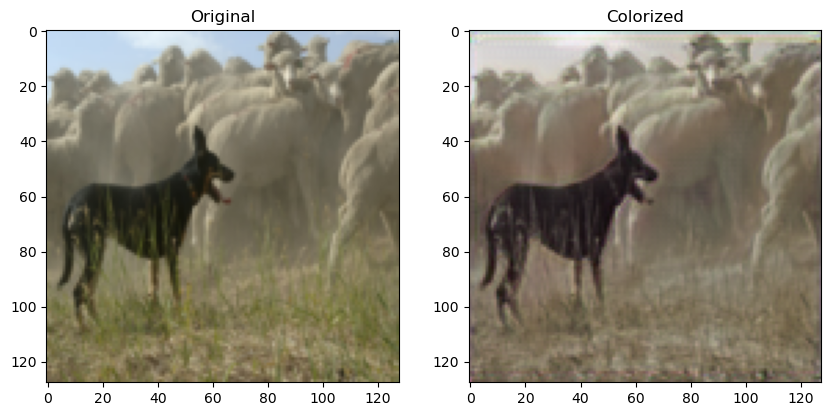

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


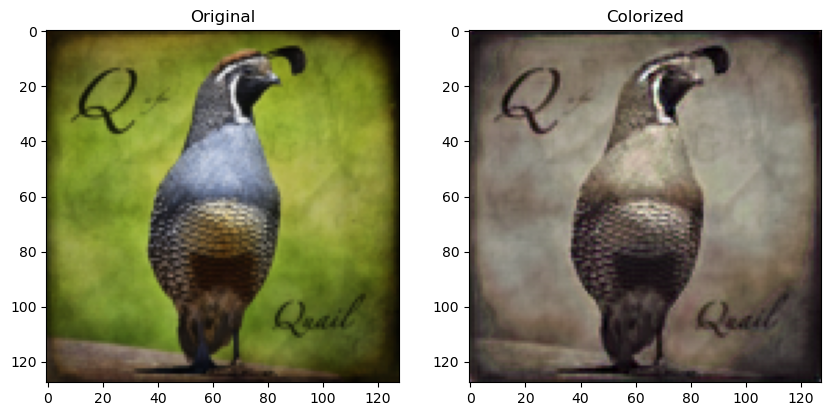

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


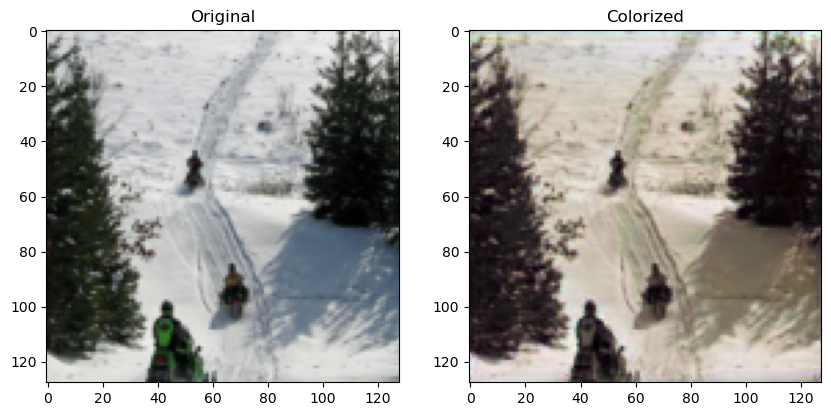

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 0 Axes>

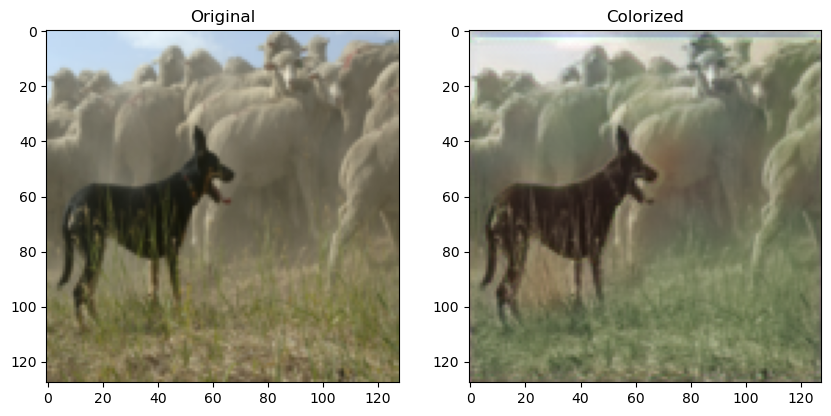

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


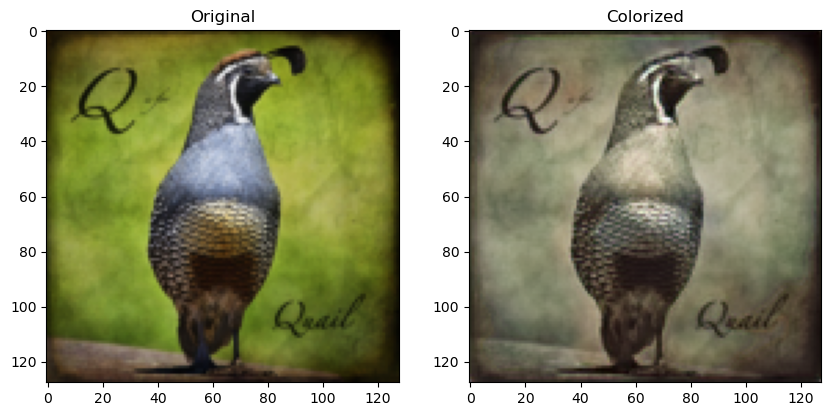

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


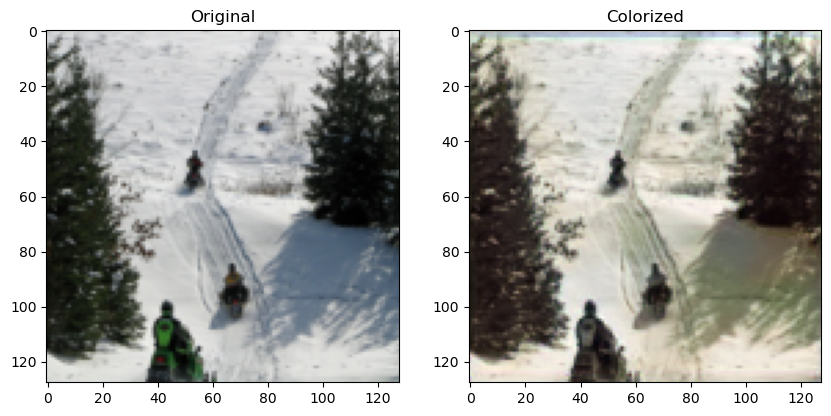

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 0 Axes>

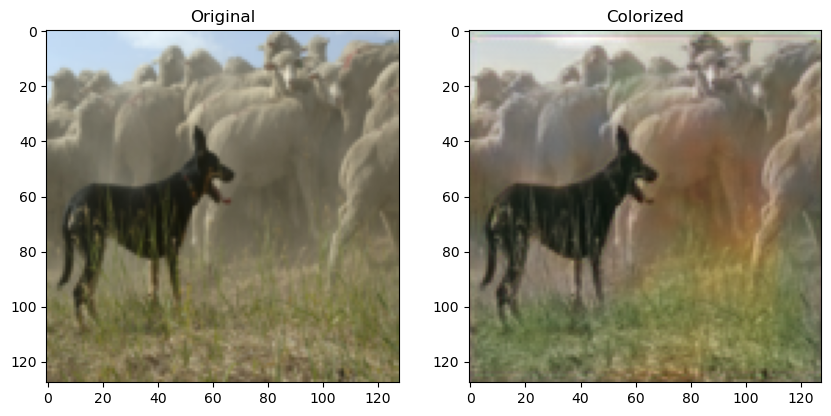

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


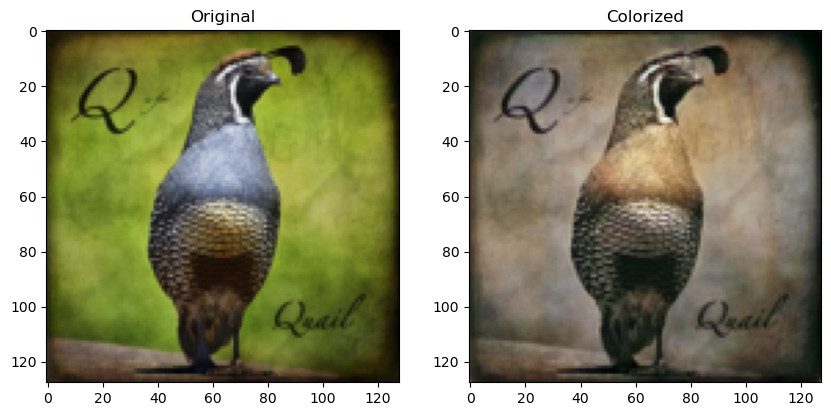

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


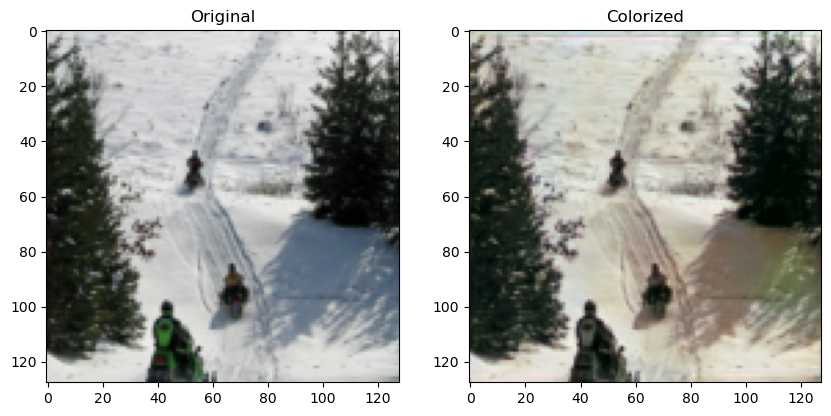

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 0 Axes>

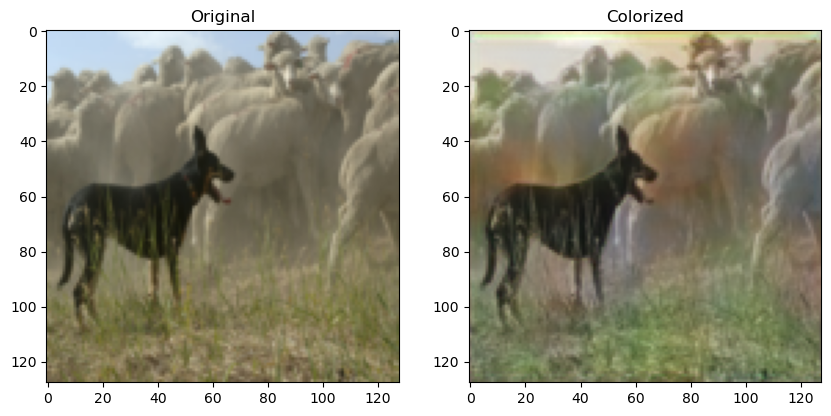

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


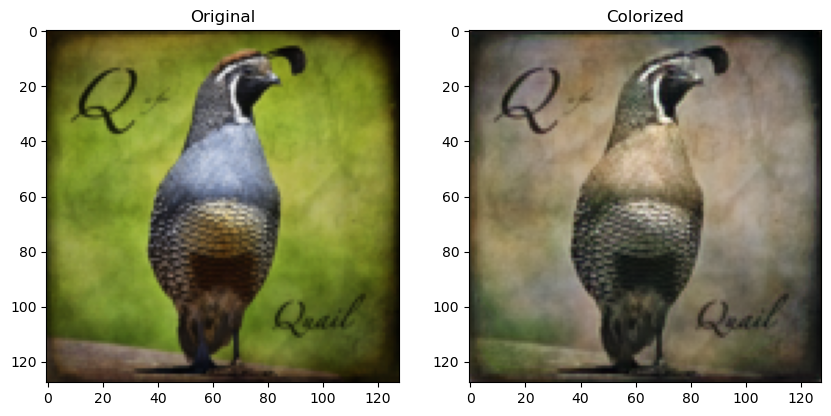

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


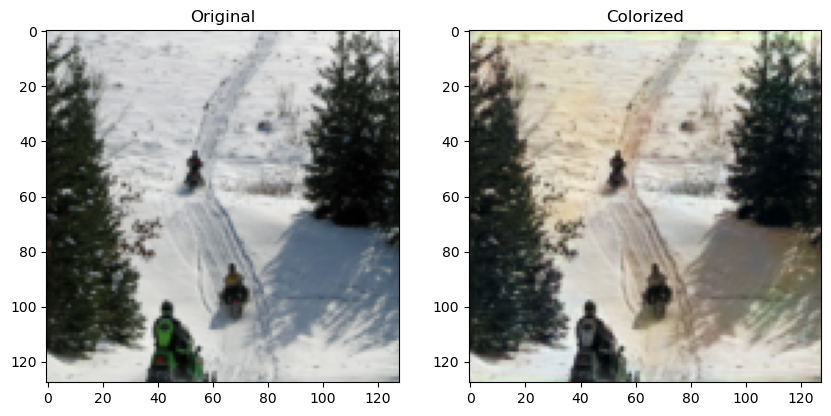

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 0 Axes>

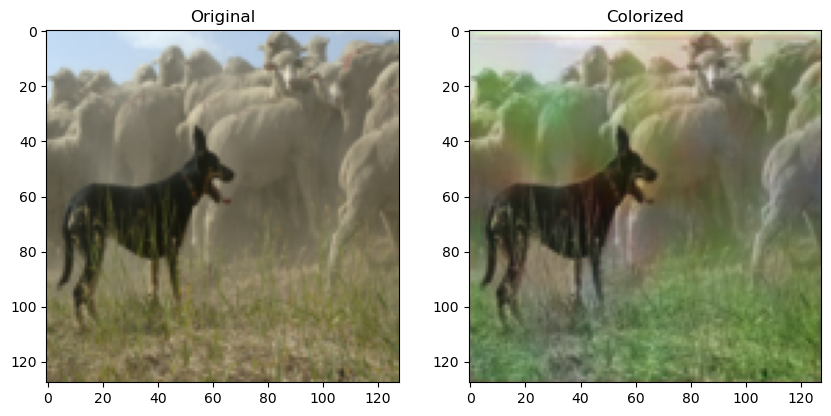

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


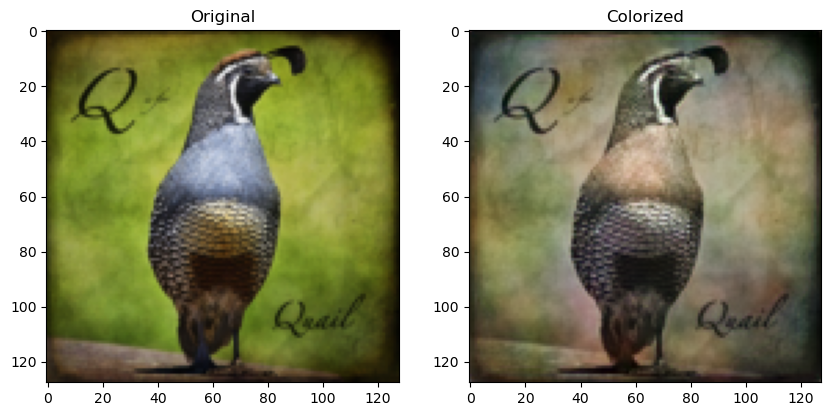

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


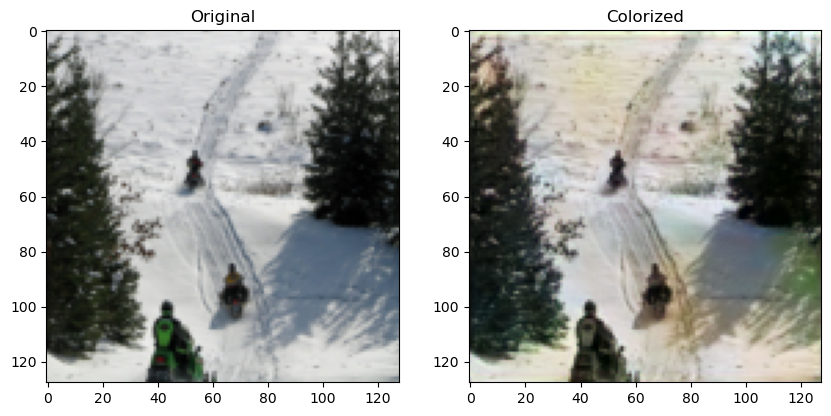

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [19]:
print("Device is: ", device)
model = UNetREG(in_C=1, out_C=3).to(device)

model = load_model_from_checkpoint("./colorisation/UNetREG_trsize50_valsize5nope_best_model.pth.tar")
model = model.to(device)

model.train_model(train_loader=train_loader, val_loader=validation_loader, 
                        epochs=300, lr=1e-4, 
                        optimizer=torch.optim.Adam, verbose=False,
                        save_path= 'colorisation', 
                        save_name_prefix='/UNetREG_trsize1000_valsize100',
                        val_check_every=5,
                        plot_every=15,
                        plotting_samples=list(validation_data)[:3])

   